In [1]:
import scipy.io
from scipy import interpolate, signal
from scipy.signal import hilbert, chirp, decimate, convolve2d 
from scipy.stats import zscore

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import struct

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

import numpy as np

npl.setup()


In [2]:
lfp = np.load("Data/Depth1_67_2_to_3mins.npy")
raise_electrodes = np.load("Data/Raise_Electrodes_3_to_4mins.npy")

In [3]:
time = lfp[0]
fs = 30000 # kHz

start = time[0]
stop = time[-1]

session_bounds = nel.EpochArray([start, stop])
session_bounds

<EpochArray at 0x7f82cc2adc10: 1 epoch> of length 46.5237 seconds

In [4]:
t_start = 100

In [5]:
time_duration = 10 # seconds
snip_start = np.where(time >= t_start)[0][0]
snip_end = snip_start + time_duration*fs

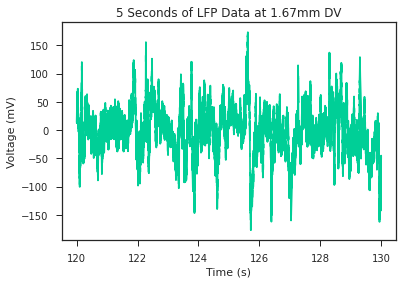

In [6]:
t = time[snip_start:snip_end]
snip = lfp[1][snip_start:snip_end]

plt.plot(t,snip) 
plt.title("5 Seconds of LFP Data at 1.67mm DV") 
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.show()


## Compare with Notch Filter

In [7]:
asa = nel.AnalogSignalArray(data=snip,time=t) 

# NOTCH FILTER 

f0 = 60 #remove freq
Q = 10 #Quality factor
w0 = f0/(fs/2) #normalized freq
#design notch filter
b, a = signal.iirnotch(w0,Q)
# Frequency response
w, h = signal.freqz(b, a)
# Generate frequency axis
freq = w*fs/(2*np.pi)

asa._ydata = signal.filtfilt(b,a,asa.ydata) #60 hz notch filter


def make_snippet(time, data, t_start=0, time_duration=1):
    snip_start = np.where(time >= t_start)[0][0]
    snip_end = snip_start + time_duration*fs
    
    t = time[snip_start:snip_end]
    snip = data[snip_start:snip_end]
    
    return t, snip

def make_asa(t,data):
    return nel.AnalogSignalArray(data=snip,time=t) 

def notch_filter(asa):
    f0 = 60 #remove freq
    Q = 10 #Quality factor
    w0 = f0/(fs/2) #normalized freq
    #design notch filter
    b, a = signal.iirnotch(w0,Q)
    # Frequency response
    w, h = signal.freqz(b, a)
    # Generate frequency axis
    freq = w*fs/(2*np.pi)

    asa._ydata = signal.filtfilt(b,a,asa.ydata) #60 hz notch filter
    
    return asa


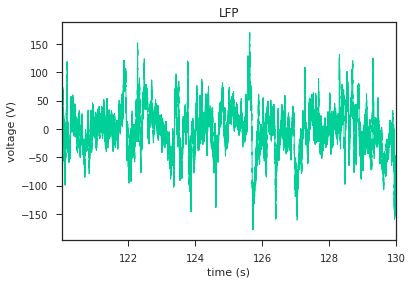

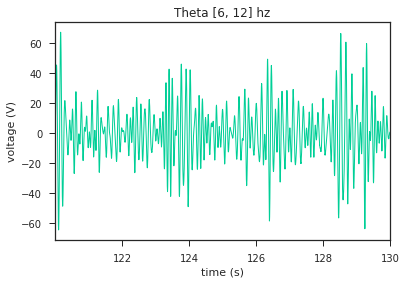

In [8]:
theta = [6, 12]
delta = [1, 4]
spike_band = [300, 6000]
gamma = [32, 100]
theta_data = nel.filtering.sosfiltfilt(asa,fl=theta[0],fh=theta[1],) 

# spike  600--6000
    # ripple 150--250
    # delta 1--4
    # theta 6--12
    # gamma 32--100
    
plt.figure()
npl.plot(asa, lw=1) 
plt.title('LFP') 
plt.show()

plt.figure()
npl.plot(theta_data, lw=1) 
plt.title('Theta ' + str(theta) + " hz") 
plt.show()

# data = nel.filtering.sosfiltfilt(asa,fl=delta[0],fh=delta[1],) 
# plt.figure()
# npl.plot(data, lw=1) 
# plt.title('Delta ' + str(delta) + " hz") 
# plt.show()

# data = nel.filtering.sosfiltfilt(asa,fl=gamma[0],fh=gamma[1],) 
# plt.figure()
# npl.plot(data, lw=1, color='k') 
# plt.title('Gamma ' + str(gamma) + " hz") 
# plt.show()

# data = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],) 
# plt.figure()
# npl.plot(data, lw=1) 
# plt.title('Spike Band ' + str(spike_band) + " hz") 
# plt.show()

<AxesSubplot:>

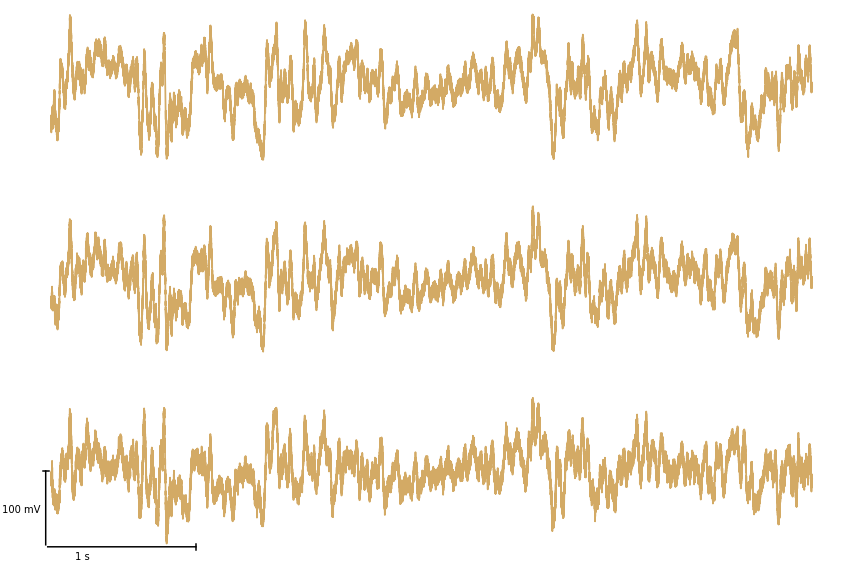

In [13]:
three_electrodes = []
for i in range(3):
    t, snip = make_snippet(time=lfp[0], data=lfp[i+1], t_start=135, time_duration=5)
    asa = make_asa(t,data=snip)
    asa = notch_filter(asa)
    three_electrodes.append(asa)
    
n_traces = 3

fig, axes = plt.subplots(n_traces, 1, figsize=(15, 10))
i = 0
for ax in axes:
    plot_data = three_electrodes[i].ydata[0]

    ax.plot(plot_data, color=colors[3])    
    i += 1
    
npl.utils.clear_left_right(*axes)
npl.utils.clear_top_bottom(*axes)
npl.scalebar.add_scalebar(ax=axes[2], sizex=1*fs, sizey=100, labely='100 mV', labelx='1 s', pad=-1, loc="lower left")

<AxesSubplot:>

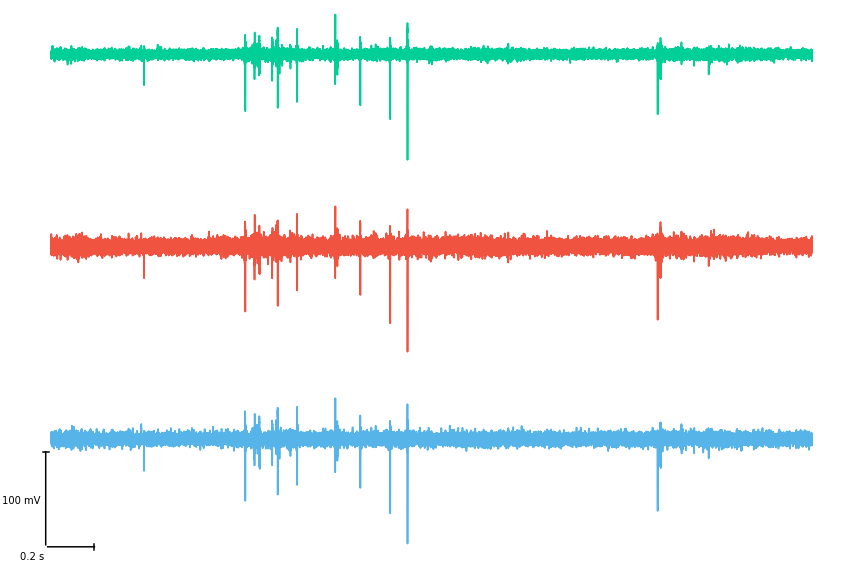

In [14]:

# Compare High Frequency Activity Among 3 Electrodes

spike_data1 = nel.filtering.sosfiltfilt(three_electrodes_raise[0],fl=spike_band[0],fh=spike_band[1],).ydata[0]
spike_data2 = nel.filtering.sosfiltfilt(three_electrodes_raise[1],fl=spike_band[0],fh=spike_band[1],).ydata[0]
spike_data3 = nel.filtering.sosfiltfilt(three_electrodes_raise[2],fl=spike_band[0],fh=spike_band[1],).ydata[0]

mean_signal = np.mean([spike_data1,spike_data2,spike_data3],axis=0)

plot_data = []

# plot_data.append(spike_data1-spike_data1)
# plot_data.append(spike_data2-spike_data1)
# plot_data.append(spike_data3-spike_data1)

# plot_data.append(spike_data1-mean_signal)
# plot_data.append(spike_data2-mean_signal)
# plot_data.append(spike_data3-mean_signal)
plot_data.append(spike_data1)
plot_data.append(spike_data2)
plot_data.append(spike_data3)

colors = ['#00CF97','#F05340','#56B4E9','#D3AA65','#B47CC7','#C44E52']
           

n_traces = 3
fig, axes = plt.subplots(n_traces, 1, figsize=(15, 10))
i = 0

for ax in axes:
    ax.plot(plot_data[i], color=colors[i])    
    i += 1
    
npl.utils.clear_left_right(*axes)
npl.utils.clear_top_bottom(*axes)
npl.scalebar.add_scalebar(ax=axes[2], sizex=1*fs/5, sizey=100, labely='100 mV', labelx='0.2 s', pad=-1, loc="lower left")


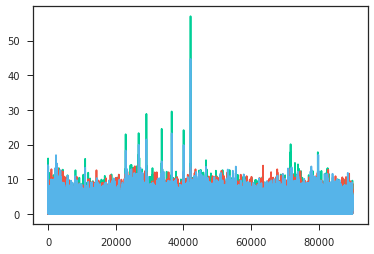

In [22]:
plt.plot(np.abs(plot_data[1] - plot_data[0]))
plt.plot(np.abs(plot_data[1] - plot_data[2]))
plt.plot(np.abs(plot_data[2] - plot_data[0]))

In [ ]:
# three_electrodes[0].time

In [ ]:
# three_signals = [three_electrodes[0].ydata[0],three_electrodes[1].ydata[0],three_electrodes[2].ydata[0]]
# time = three_electrodes[0].time - np.min(three_electrodes[0].time)

# plt.figure(figsize=(15,15))
# plt.rcParams.update({'font.size': 20})

# plt.subplot(2,1,1)
# plt.plot(time,three_signals[0],label="Electrode 1")

# plt.plot(time,three_signals[1]-200, label="Electrode 2")

# plt.plot(time,three_signals[2]-400,label="Electrode 3")

# plt.axvline(time[132000],color="gray")
# plt.axvline(time[144000],color="gray")
# plt.axvline(time[144000],color="gray")

# plt.title("LFP from 3 adjacent electrodes", fontsize = 20)
# plt.yticks(ticks=[],labels=None)
# plt.xticks(fontsize=15)
# plt.xlabel("Time (s)\n",fontsize=20)

# plt.vlines(x = -0.2, ymin = -450, ymax = -350,color="k")
# plt.hlines(y = -450, xmin = -0.25, xmax = -0.15,color="k")
# plt.hlines(y = -350, xmin = -0.25, xmax = -0.15,color="k")
# # plt.legend(loc="upper left", fontsize=15)


# def x_norm(x):
#     return (x-np.min(x))/(np.max(x)-np.min(x))

# plt.subplot(2,1,2)

# plt.plot(time,x_norm(np.abs(three_signals[0])**2),label="Electrode 1")

# plt.plot(time,x_norm(np.abs(three_signals[1])**2),label="Electrode 2")

# plt.plot(time,x_norm(np.abs(three_signals[2])**2),label="Electrode 3")

# plt.xlim(time[132000],time[144000])
# plt.yticks(fontsize=15)
# plt.xticks(fontsize=15)
# plt.xlabel("Time (s)", fontsize=20)
# plt.ylabel("Normalized Signal Power",fontsize=20)
# plt.legend(fontsize=25)


# plt.title("Normalized Power", fontsize=20)
# plt.show()


# # plt.plot(time,np.abs(three_signals[0])**2)

# # plt.plot(time,np.abs(three_signals[1])**2)

# # plt.plot(time,np.abs(three_signals[2])**2)

# # plt.title("Power of Signals")
# # plt.yticks(ticks=[],labels=None)
# # plt.show()


In [ ]:
# three_signals = [three_electrodes[0].ydata[0],three_electrodes[1].ydata[0],three_electrodes[2].ydata[0]]

# mean_signal = np.mean(three_signals,axis=0)
# three_signals_diff = []

# for i in range(3):
#     three_signals_diff.append(three_signals[i] - mean_signal)
    
# plt.plot(mean_signal)

# plt.plot(three_signals_diff[0]-200)

# plt.plot(three_signals_diff[1]-400)

# plt.plot(three_signals_diff[2]-600)

# plt.title("Elec 1,2,3 Subtracted by Mean")

# plt.show()
    
# # plt.plot(three_signals[1] - three_signals[0])

# # plt.plot(three_signals[2] - three_signals[0])

# signal_comparison = []
# signal_comparison.append(three_signals[0])
# signal_comparison.append(three_signals[1] - three_signals[0])
# signal_comparison.append(three_signals[2] - three_signals[0])


# plt.plot(signal_comparison[0])

# plt.plot(signal_comparison[1]-200)

# plt.plot(signal_comparison[2]-400)

# plt.title("Ref = Elec 1, Elec 2, Elec 3")

# plt.show()


# signal_comparison = []
# signal_comparison.append(three_signals[0] - three_signals[1])
# signal_comparison.append(three_signals[1])
# signal_comparison.append(three_signals[2]- three_signals[1])


# plt.plot(signal_comparison[0])

# plt.plot(signal_comparison[1]-200)

# plt.plot(signal_comparison[2]-400)

# plt.title("Elec 1, Ref = Elec 2, Elec 3")

# plt.show()

# # check_cross_talk = []

# # for i in range(3):
# #     asa = make_asa(t,data=signal_comparison[i])
# #     check_cross_talk.append(asa)
    
    
# # fig, axes = plt.subplots(3, 1, figsize=(15, 10))
# # i = 0
# # for ax in axes:
# #     plot_data = check_cross_talk[i].ydata[0]

# #     ax.plot(plot_data, color=colors[3])    
# #     i += 1
    
# # npl.utils.clear_left_right(*axes)
# # npl.utils.clear_top_bottom(*axes)
# # npl.scalebar.add_scalebar(ax=axes[2], sizex=1*fs, sizey=100, labely='100 mV', labelx='1 s', pad=-1, loc="lower left")

<AxesSubplot:>

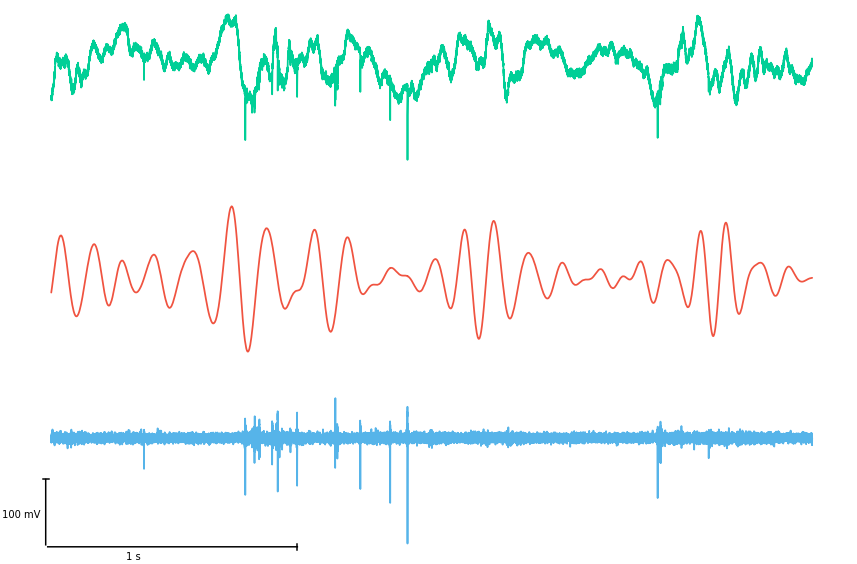

In [10]:
three_electrodes_raise = []
for i in range(3):
    t, snip = make_snippet(time=raise_electrodes[0], data=raise_electrodes[i+1], t_start=196, time_duration=3)
    asa = make_asa(t,data=snip)
    asa = notch_filter(asa)
    three_electrodes_raise.append(asa)
    
lfp_data = three_electrodes_raise[0].ydata[0]
theta_data = nel.filtering.sosfiltfilt(three_electrodes_raise[0],fl=theta[0],fh=theta[1],).ydata[0]
spike_data = nel.filtering.sosfiltfilt(three_electrodes_raise[0],fl=spike_band[0],fh=spike_band[1],).ydata[0]

plot_data = []
plot_data.append(lfp_data)
plot_data.append(theta_data)
plot_data.append(spike_data)

colors = ['#00CF97','#F05340','#56B4E9','#D3AA65','#B47CC7','#C44E52']
           

n_traces = 3
fig, axes = plt.subplots(n_traces, 1, figsize=(15, 10))
i = 0

for ax in axes:
    ax.plot(plot_data[i], color=colors[i])    
    i += 1
    
npl.utils.clear_left_right(*axes)
npl.utils.clear_top_bottom(*axes)
npl.scalebar.add_scalebar(ax=axes[2], sizex=1*fs, sizey=100, labely='100 mV', labelx='1 s', pad=-1, loc="lower left")

In [11]:
theta_data

array([-13.89770043, -13.84883706, -13.7971707 , ...,   0.11180579,
         0.11670619,   0.120443  ])

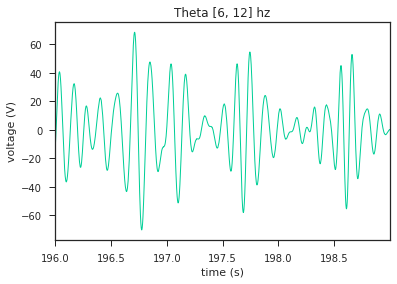

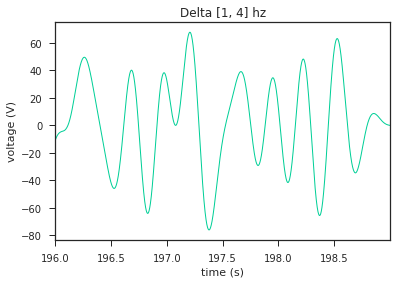

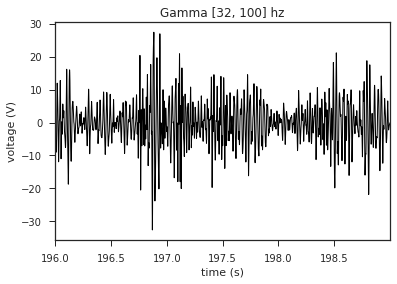

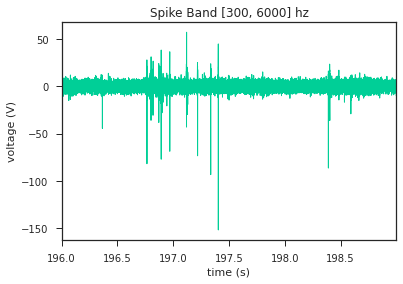

In [12]:
asa = three_electrodes_raise[0]

theta_data = nel.filtering.sosfiltfilt(asa,fl=theta[0],fh=theta[1],) 
plt.figure()
npl.plot(theta_data, lw=1) 
plt.title('Theta ' + str(theta) + " hz") 
plt.show()

data = nel.filtering.sosfiltfilt(asa,fl=delta[0],fh=delta[1],) 
plt.figure()
npl.plot(data, lw=1) 
plt.title('Delta ' + str(delta) + " hz") 
plt.show()

data = nel.filtering.sosfiltfilt(asa,fl=gamma[0],fh=gamma[1],) 
plt.figure()
npl.plot(data, lw=1, color='k') 
plt.title('Gamma ' + str(gamma) + " hz") 
plt.show()

data = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],) 
plt.figure()
npl.plot(data, lw=1) 
plt.title('Spike Band ' + str(spike_band) + " hz") 
plt.show()

In [ ]:
plt.plot(raise_electrodes[0], raise_electrodes[1])

In [ ]:
plt.plot(lfp[0], lfp[1])